# **Proyecto 1 – Parte final (Core)**

## **Clasificación basada en arboles**

### **Proyecto 1: Análisis y Predicción de Ventas en una Tienda de Retail**

**Objetivo:** Realizar un análisis exploratorio de datos (EDA) completo, preprocesamiento y benchmarking de técnicas de machine learning para predecir ventas en una tienda de retail. Además, generar un análisis de métricas y crear una presentación de una página (one-page) en PPT para explicar los resultados. Todo el trabajo debe ser subido como una versión de liberación (v1.0.0) en GitHub.



### **Parte 1. Exploración y Visualizacion de Datos (EDA)**

**1. Carga y Exploración Inicial de Datos:**
- Cargar el dataset y revisar su estructura básica.
- Describir las variables y su distribución.
- Identificar y tratar valores nulos y outliers.


In [4]:
# Se importan las librerias
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

**Cargar el dataset y revisar su estructura básica.**

In [6]:
# Importamos la libreria para montar Google Drive

from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/Colab Notebooks/BD/retail_sales_dataset.csv"
df = pd.read_csv(path)

df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100
...,...,...,...,...,...,...,...,...,...
995,996,2023-05-16,CUST996,Male,62,Clothing,1,50,50
996,997,2023-11-17,CUST997,Male,52,Beauty,3,30,90
997,998,2023-10-29,CUST998,Female,23,Beauty,4,25,100
998,999,2023-12-05,CUST999,Female,36,Electronics,3,50,150


In [7]:
# Se revisa la estructura del DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    1000 non-null   int64 
 1   Date              1000 non-null   object
 2   Customer ID       1000 non-null   object
 3   Gender            1000 non-null   object
 4   Age               1000 non-null   int64 
 5   Product Category  1000 non-null   object
 6   Quantity          1000 non-null   int64 
 7   Price per Unit    1000 non-null   int64 
 8   Total Amount      1000 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 70.4+ KB


**Describir las variables y su distribución.**

In [8]:
# Veremos la estadistica de las columnas
df.describe()

,Transaction ID,Age,Quantity,Price per Unit,Total Amount
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000
mean,500.500000,41.39200,2.514000,179.890000,456.000000
std,288.819436,13.68143,1.132734,189.681356,559.997632
min,1.000000,18.00000,1.000000,25.000000,25.000000
25%,250.750000,29.00000,1.000000,30.000000,60.000000
50%,500.500000,42.00000,3.000000,50.000000,135.000000
75%,750.250000,53.00000,4.000000,300.000000,900.000000
max,1000.000000,64.00000,4.000000,500.000000,2000.000000


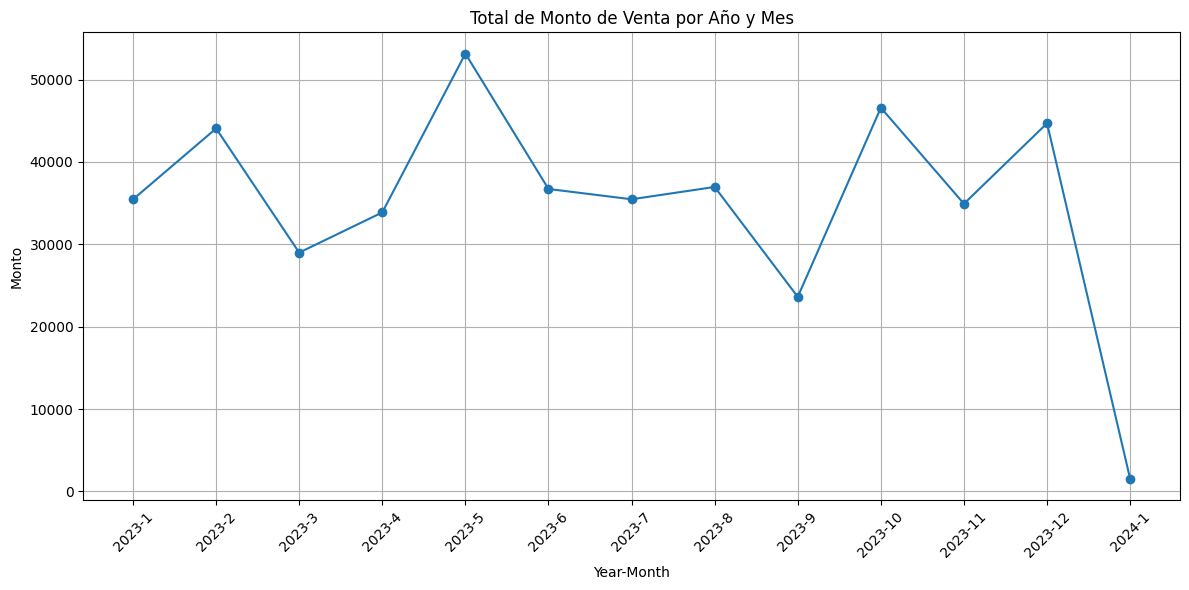

In [10]:
# Grafico para visualizar Total Amount por año y mes

# Convertir la columna 'Date' a datetime, es es de tipo objects
df['Date'] = pd.to_datetime(df['Date'])

# Extraer el Año (Year) de la fecha
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Hacemos una suma agrupada por Year y Month, del monto total
ventas = df.groupby(['Year','Month'])['Total Amount'].sum().reset_index()

# Combine Year and Month for plotting
ventas['Year_Month'] = ventas['Year'].astype(str) + '-' + ventas['Month'].astype(str)

# Graficamos el Monto de Ventas por Año y Mes
plt.figure(figsize=(12, 6))
plt.plot(ventas['Year_Month'], ventas['Total Amount'], marker='o', linestyle='-')
plt.xlabel('Year-Month')
plt.ylabel('Monto')
plt.title('Total de Monto de Venta por Año y Mes')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Vemos en el grafico que cada mes las ventas varian, tanto en aumento como en bajas... en el ultimo mes las ventas casi estan en cero.

**Identificar y tratar valores nulos y outliers.**

In [12]:
# se revisan los tipos de datos del dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    1000 non-null   int64         
 1   Date              1000 non-null   datetime64[ns]
 2   Customer ID       1000 non-null   object        
 3   Gender            1000 non-null   object        
 4   Age               1000 non-null   int64         
 5   Product Category  1000 non-null   object        
 6   Quantity          1000 non-null   int64         
 7   Price per Unit    1000 non-null   int64         
 8   Total Amount      1000 non-null   int64         
 9   Year              1000 non-null   int32         
 10  Month             1000 non-null   int32         
dtypes: datetime64[ns](1), int32(2), int64(5), object(3)
memory usage: 78.3+ KB


In [14]:
# De tomos confirmamos la explicacion anterior
df.isna().sum()

,0
Transaction ID,0
Date,0
Customer ID,0
Gender,0
Age,0
Product Category,0
Quantity,0
Price per Unit,0
Total Amount,0
Year,0


No exisen valores nulos

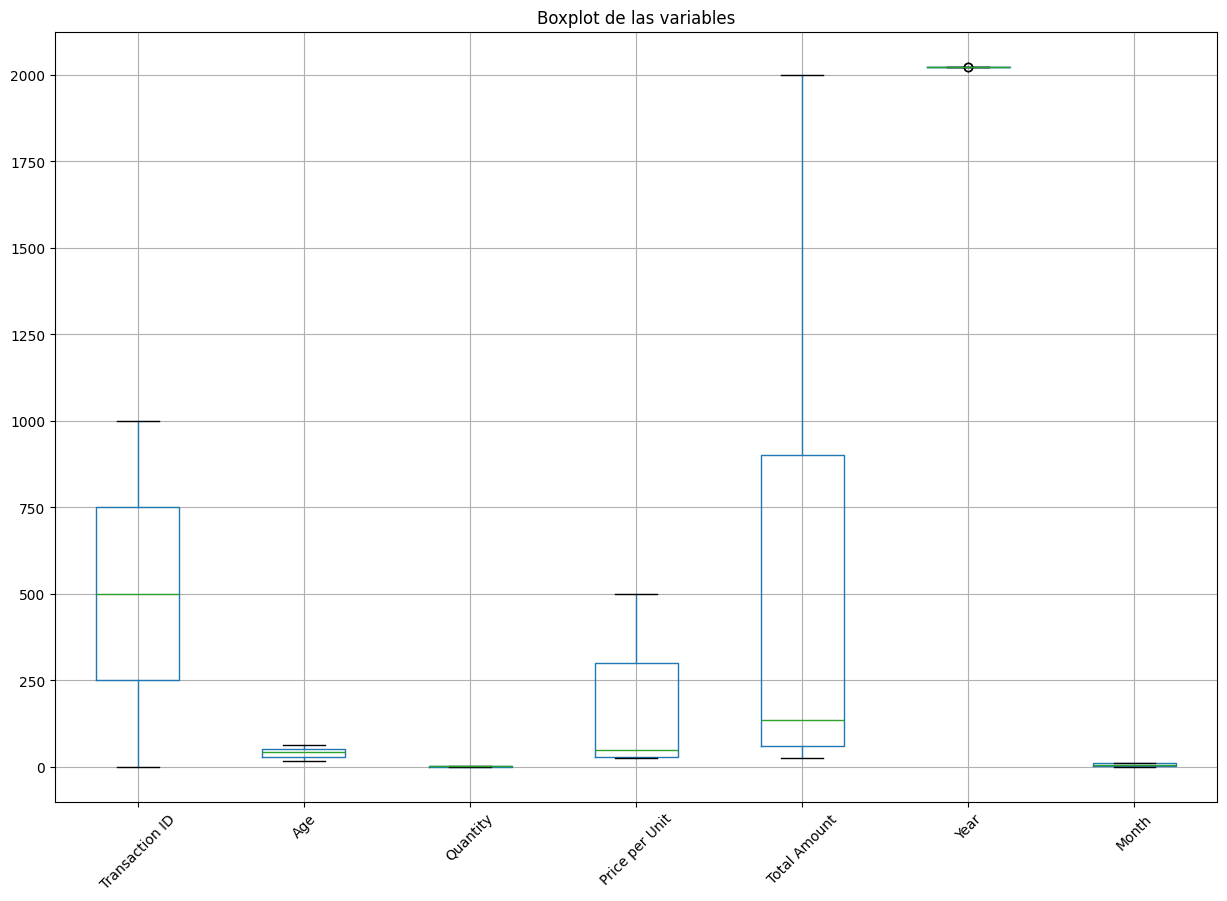

In [15]:
# Se generan graficos boxplot de las variables

import matplotlib.pyplot as plt
# graficos boxplot de las variables del dataframe
plt.figure(figsize=(15, 10))
df.boxplot()
plt.title('Boxplot de las variables')
plt.xticks(rotation=45)
plt.show()

De acuerdo al gráfico anterior se puede concluir que no existen valores outliers.

### **2. Análisis de Correlación:**
- Realizar un análisis de correlación y crear un mapa de calor para visualizar las relaciones entre las variables.

**Realizar un análisis de correlación y crear un mapa de calor para visualizar las relaciones entre las variables.**





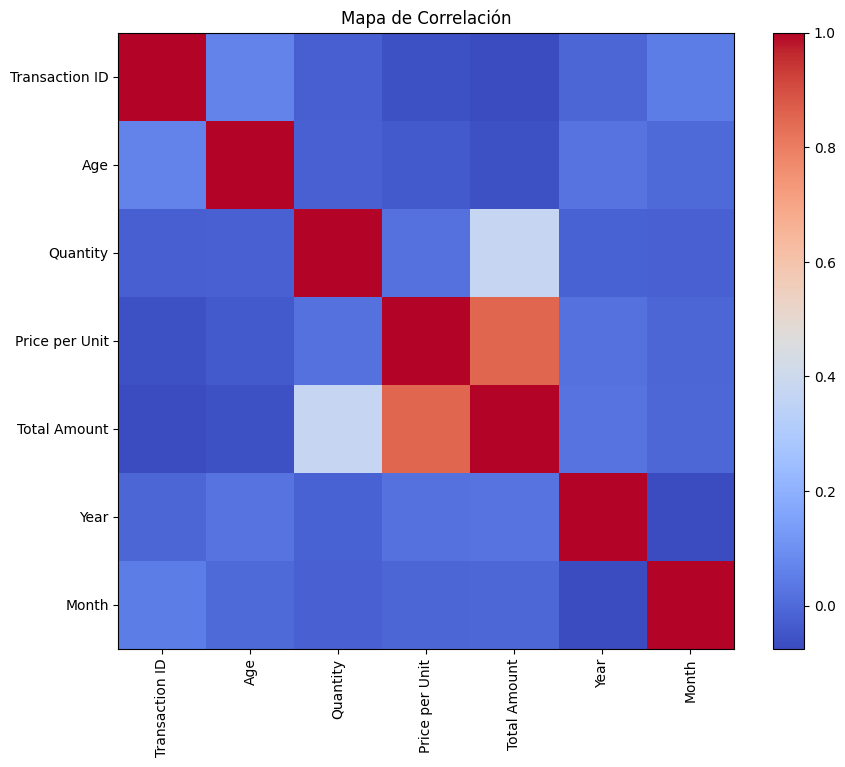

In [17]:
# Se genera mapa de calor de las variables numericas
numeric_df = df.select_dtypes(include=np.number) # Select only numeric columns
corr_matrix = numeric_df.corr()
plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Mapa de Correlación')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.show()

De acuerdo al gráfico anterior se puede que las columnas Price per Unit y Total Amount son las variables que tienen mas correlacion

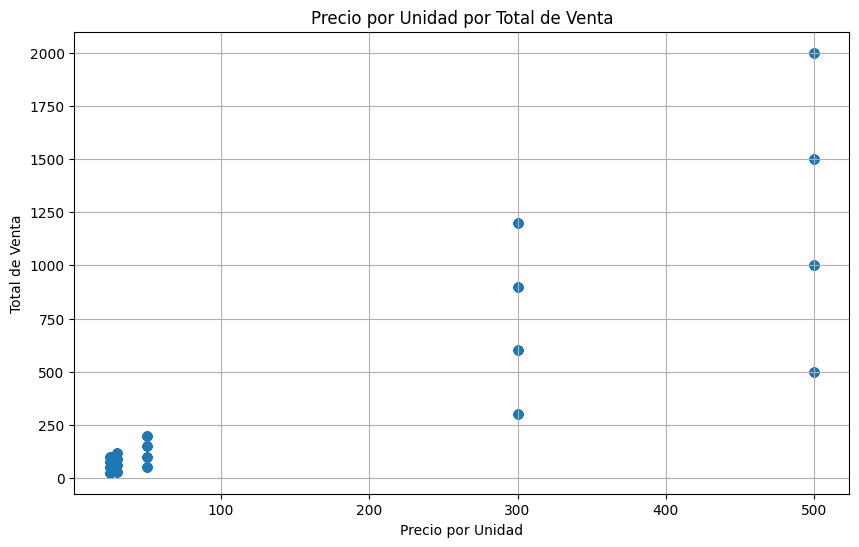

In [18]:
# Se genera gráfico scatter para las columnas Price per Unit y Total Amount
plt.figure(figsize=(10, 6))
plt.scatter(df['Price per Unit'], df['Total Amount'], alpha=0.5)
plt.xlabel('Precio por Unidad')
plt.ylabel('Total de Venta')
plt.title('Precio por Unidad por Total de Venta')
plt.grid(True)
plt.show()

### **Visualización de Datos:**
- Crear subplots para comparar diferentes variables clave.
- Añadir cuadrículas, leyendas, anotaciones y flechas a los gráficos para mejorar la claridad y la información.

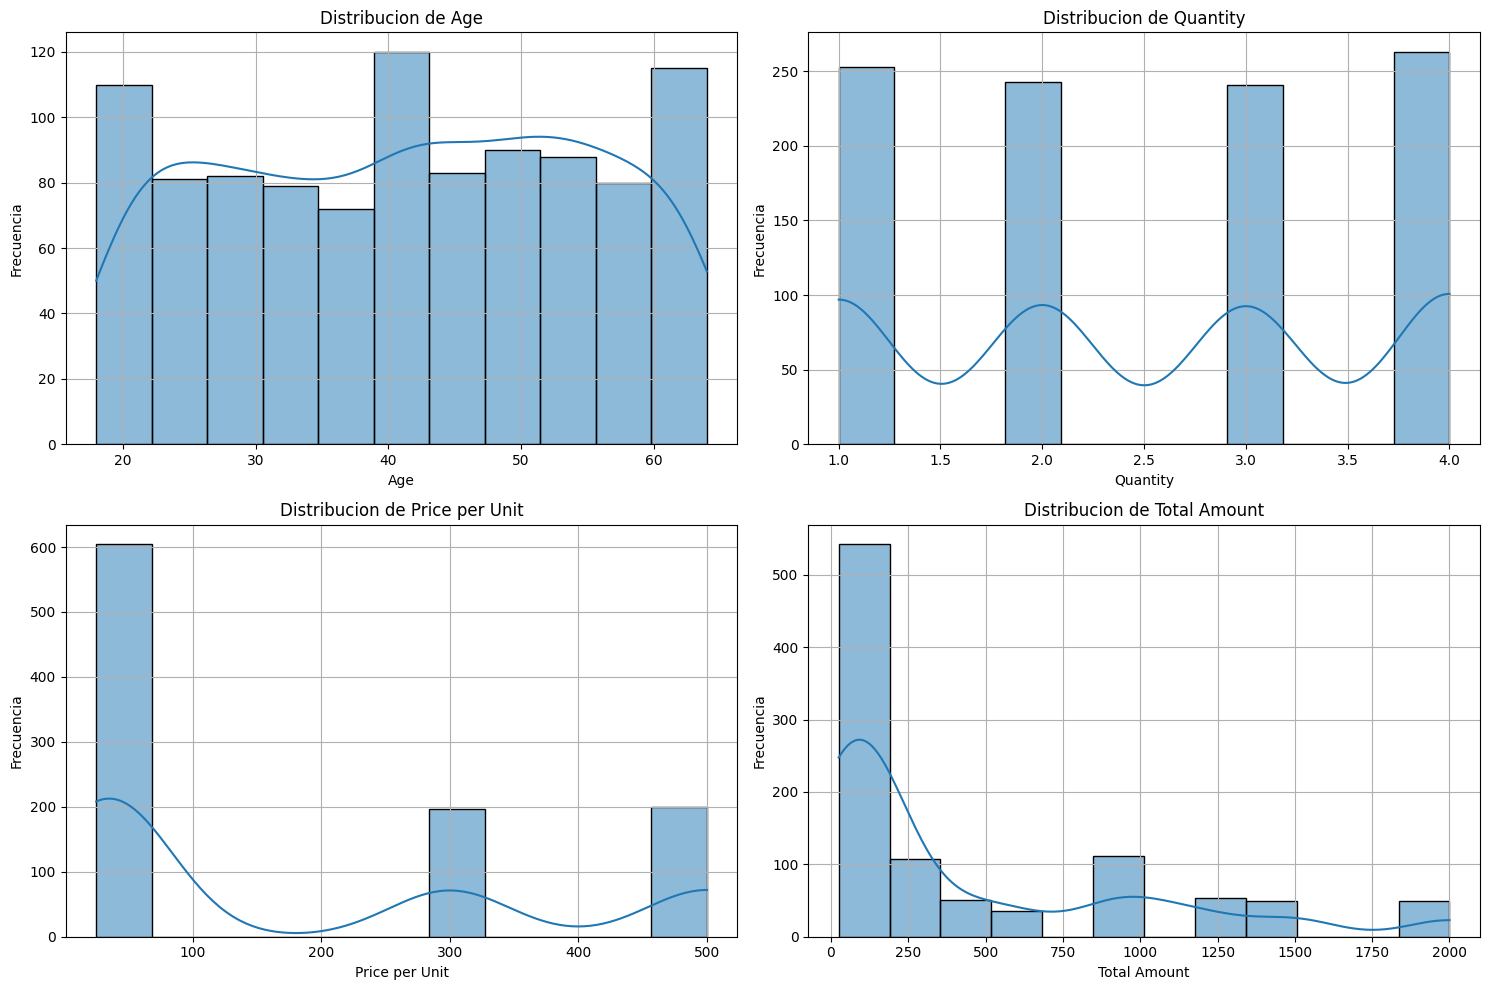

In [19]:
# Grafico subplots para comparar diferentes variables claves

# Se asignan las variables a graficar
var = ['Age', 'Quantity', 'Price per Unit', 'Total Amount']

# Se crea un subplots de 2x2 para 4 graficos
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, var in enumerate(var):
    sns.histplot(df[var], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribucion de {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frecuencia')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frecuencia')
    axes[i].grid(True)

plt.tight_layout()
plt.show()




### **Parte 2: Preprocesamiento de Datos**

**Transformación de Columnas:**
- Utilizar ColumnTransformer para aplicar transformaciones específicas a diferentes columnas.
- Realizar codificación de variables categóricas y escalado de variables numéricas.

**Pipelines:**
- Crear pipelines para automatizar el preprocesamiento de datos y asegurar la reproducibilidad.


In [20]:
# divido mi DF en Train y Test
X = df.drop(columns=["Transaction ID", "Date", "Customer ID","Total Amount"])
y = df["Total Amount"]

**Utilizar ColumnTransformer para aplicar transformaciones específicas a diferentes columnas.**

**Realizar codificación de variables categóricas y escalado de variables numéricas.**

In [21]:
# Definir transformadores.
num_cols = ["Age", "Quantity", "Price per Unit", "Year", "Month"]
nom_cols = ["Gender", "Product Category"]

In [22]:
 # Definir transformadores.
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), num_cols),
    ("nom", OneHotEncoder(handle_unknown='ignore'), nom_cols),
])


**Crear pipelines para automatizar el preprocesamiento de datos y asegurar la reproducibilidad.**

In [23]:
# Usando Traint_Test_Split dejamos 80% para entrenar y 20% para validad
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Pipeline para modelos:

- Arbol de Decision
- KNN
- RandomForest

**Arbol de Decision**

In [24]:
# Crear pipeline para Arbol de Decision.
pipeline_tree = Pipeline(steps=[
    ("preprocessing", preprocessor), # Uanque no es necesario para el arbol de decision, escalaremos
    ("classifier", DecisionTreeRegressor())
])

In [25]:
# Desplegamos la estructura del Pipeline
pipeline_tree

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Quantity',
                                                   'Price per Unit', 'Year',
                                                   'Month']),
                                                 ('nom',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender',
                                                   'Product Category'])])),
                ('classifier', DecisionTreeRegressor())])

**KNN**

In [26]:
# Crear pipeline para KNN.
pipeline_knn = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("classifier", KNeighborsRegressor())
])

In [27]:
# Desplegamos la estructura del Pipeline
pipeline_knn

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Quantity',
                                                   'Price per Unit', 'Year',
                                                   'Month']),
                                                 ('nom',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender',
                                                   'Product Category'])])),
                ('classifier', KNeighborsRegressor())])

**Ramdom Forest**

In [28]:
# Crear pipeline para RF.
pipeline_rf = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("classifier", RandomForestRegressor())
])

In [29]:
# Desplegamos la estructura del Pipeline
pipeline_rf

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Quantity',
                                                   'Price per Unit', 'Year',
                                                   'Month']),
                                                 ('nom',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender',
                                                   'Product Category'])])),
                ('classifier', RandomForestRegressor())])

### **Parte 3: Benchmarking de Técnicas de Machine Learning**

**Selección de Modelos:**
- Entrenar y evaluar múltiples modelos de machine learning (por ejemplo, Regresión Lineal, KNN, Árbol de Decisión, Random Forest, XGBoost y LGBM).
- Utilizar validación cruzada para evaluar el rendimiento de los modelos.

**Comparación de Modelos:**

- Comparar los modelos utilizando métricas de rendimiento como exactitud, precisión, recall, F1-Score y ROC-AUC.
- Seleccionar el mejor modelo basado en las métricas obtenidas.

**Entrenar y evaluar múltiples modelos de machine learning**

Para este proyecto, utilizo Árbol de Decisión, KNN, Random Forest.

In [30]:
# entrena modelos con validacion cruzada
from sklearn.model_selection import cross_val_score

# Aplicamos validacion cruzada a los modelos
scores_tree = cross_val_score(pipeline_tree, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
scores_knn = cross_val_score(pipeline_knn, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
scores_rf = cross_val_score(pipeline_rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')


**Comparación de Modelos:**

- Comparar los modelos utilizando métricas de rendimiento como exactitud, precisión, recall, F1-Score y ROC-AUC.
- Seleccionar el mejor modelo basado en las métricas obtenidas.

**Evaluar los modelos utilizando métricas como exactitud, precisión, recall, F1-Score y matriz de confusión.**

In [31]:
# Fit the pipelines to the training data
pipeline_tree.fit(X_train, y_train)
pipeline_knn.fit(X_train, y_train)
pipeline_rf.fit(X_train, y_train)

# Probamos los modelo
y_pred_tree = pipeline_tree.predict(X_test)
y_pred_knn = pipeline_knn.predict(X_test)
y_pred_rf = pipeline_rf.predict(X_test)

In [32]:
# Evaluar los modelos utilizando métricas como exactitud, precisión, recall, F1-Score y matriz de confusión.

# Precision_score
precision_tree = precision_score(y_test, y_pred_tree, average='weighted')
precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')

# se imprime resultados
print("Precision Arbol de Decision:", precision_tree)
print("Precision KNN:", precision_knn)
print("Precision Random Forest:", precision_rf)

Precision Arbol de Decision: 1.0
Precision KNN: 0.1425
Precision Random Forest: 1.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


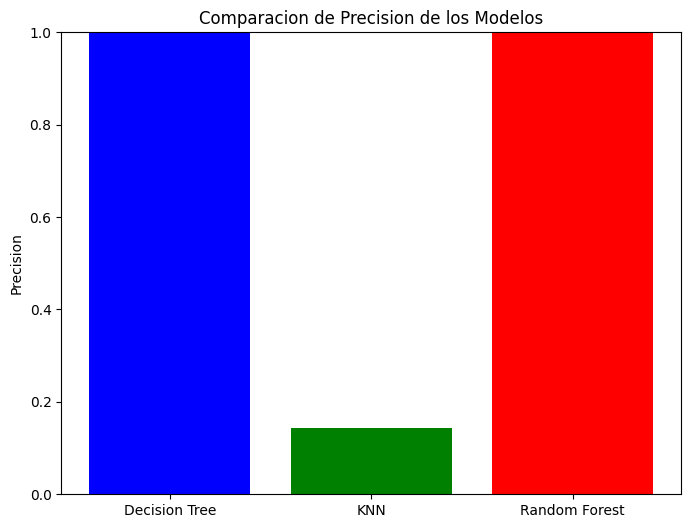

In [34]:
# Se grafica resultados en un grafico de barra
models = ['Decision Tree', 'KNN', 'Random Forest']
precisions = [precision_tree, precision_knn, precision_rf]


plt.figure(figsize=(8, 6))
plt.bar(models, precisions, color=['blue', 'green', 'red'])
plt.ylabel('Precision')
plt.title('Comparacion de Precision de los Modelos')
plt.ylim(0, 1) # seteamos los ejes
plt.show()



Como conclusion del gráfico anterior se puede decir que tanto el modelo Decision Tree como el Random Forest tienen una Precisión alta (100%). Esto implica que, cuando estos modelos hacen una predicción "positiva" para una clase, serian extremadamente fiables.
Por otra parte, se evidencia un rendimiento bajo del modelo KNN: con una Precisión baja (15%). Esto lo convierte en un modelo poco fiable para este problema de clasificación, ya que produce una gran cantidad de falsos positivos.

In [36]:
# Se aplica la evaluación de modelos utilizando recall
recall_tree = recall_score(y_test, y_pred_tree, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')

# se imprime resultados
print("Recall Arbol de Decision:", recall_tree)
print("Recall KNN:", recall_knn)
print("Recall Random Forest:", recall_rf)

Recall Arbol de Decision: 1.0
Recall KNN: 0.035
Recall Random Forest: 1.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


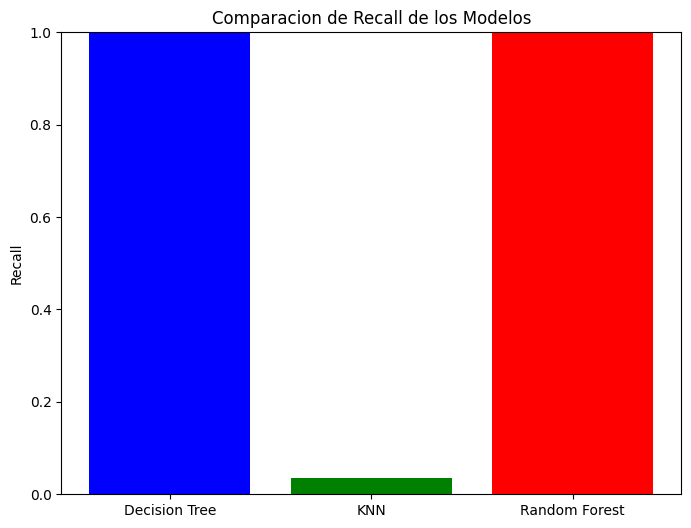

In [37]:
# Se imprimen los resultados en un Grafico de barras
models = ['Decision Tree', 'KNN', 'Random Forest']
recalls = [recall_tree, recall_knn, recall_rf]


plt.figure(figsize=(8, 6))
plt.bar(models, recalls, color=['blue', 'green', 'red'])
plt.ylabel('Recall')
plt.title('Comparacion de Recall de los Modelos')
plt.ylim(0, 1) # seteamos los ejes
plt.show()

In [38]:
# Evluación de modelos mediante F1-Score
f1_tree = f1_score(y_test, y_pred_tree, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

# se imprime resultados
print("F1-Score Arbol de Decision:", f1_tree)
print("F1-Score KNN:", f1_knn)
print("F1-Score Random Forest:", f1_rf)

F1-Score Arbol de Decision: 1.0
F1-Score KNN: 0.055508870214752565
F1-Score Random Forest: 1.0


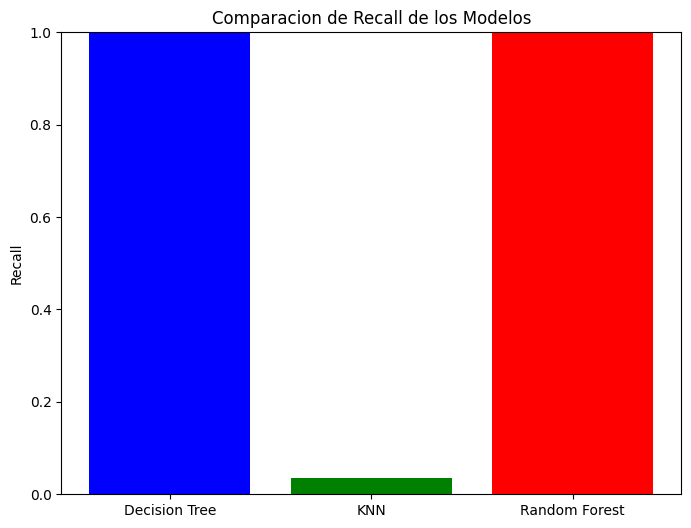

In [39]:
# # Se imprimen los resultados en un Grafico de barras
models = ['Decision Tree', 'KNN', 'Random Forest']
recalls = [recall_tree, recall_knn, recall_rf]


plt.figure(figsize=(8, 6))
plt.bar(models, recalls, color=['blue', 'green', 'red'])
plt.ylabel('Recall')
plt.title('Comparacion de Recall de los Modelos')
plt.ylim(0, 1)
plt.show()


Tal como se dijo anteriormenete, todos los gráficos desplegados permiten apreciar que tanto El Arbol de Decision como Ramdom Forest son los que presentan un mejor porcentaje (100%).

### **Parte 4: Análisis de Métricas**

**Informe de Clasificación:**
- Generar un informe de clasificación para los modelos evaluados.
- Incluir la matriz de confusión para una comprensión detallada de los errores de clasificación.

**Curva ROC y AUC:**
- Crear y visualizar la curva ROC para los modelos de clasificación binaria.
- Calcular el AUC para evaluar la capacidad del modelo para distinguir entre clases.

**Matriz de Confusion**

In [40]:
# Se genera matriz de confusión
cm_tree = confusion_matrix(y_test, y_pred_tree)
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_rf = confusion_matrix(y_test, y_pred_rf)

In [42]:
# Se visualizan los resultados de las Matrices
print("Matriz de confusión Arbol de Decision:\n", cm_tree)
print("Matriz de confusión KNN:\n", cm_knn)
print("Matriz de confusión Random Forest:\n", cm_rf)

Matriz de confusión Arbol de Decision:
 [[10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 23  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 14  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 12  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

**Generar un informe de clasificación para cada modelo**

In [46]:
# Se genera reporte por cada modelo
report_tree = classification_report(y_test, y_pred_tree)
report_knn = classification_report(y_test, y_pred_knn)
report_rf = classification_report(y_test, y_pred_rf)

# Imprimir los reportes
print("clasificación Arbol de Decision:\n", report_tree)
print("Clasificación KNN:\n", report_knn)
print("Clasificación Random Forest:\n", report_rf)


clasificación Arbol de Decision:
               precision    recall  f1-score   support

          25       1.00      1.00      1.00        10
          30       1.00      1.00      1.00         7
          50       1.00      1.00      1.00        17
          60       1.00      1.00      1.00         9
          75       1.00      1.00      1.00         8
          90       1.00      1.00      1.00         9
         100       1.00      1.00      1.00        23
         120       1.00      1.00      1.00         7
         150       1.00      1.00      1.00         9
         200       1.00      1.00      1.00        17
         300       1.00      1.00      1.00        15
         500       1.00      1.00      1.00         8
         600       1.00      1.00      1.00         5
         900       1.00      1.00      1.00        14
        1000       1.00      1.00      1.00        12
        1200       1.00      1.00      1.00        10
        1500       1.00      1.00      1.00    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

**Crear y visualizar la curva ROC y calcular el AUC para el mejor modelo.**


In [47]:
# Curva de ROC de los modelos seleccionados
# Calculo las metricas de regresi´on de cada modelo
mse_tree = mean_squared_error(y_test, y_pred_tree)
rmse_tree = np.sqrt(mse_tree)
mae_tree = mean_absolute_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)

mse_knn = mean_squared_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print the regression metrics
print("Decision Tree Regressor Metrics:")
print(f"  MSE: {mse_tree:.2f}")
print(f"  RMSE: {rmse_tree:.2f}")
print(f"  MAE: {mae_tree:.2f}")
print(f"  R-squared: {r2_tree:.2f}")

print("\nKNN Regressor Metrics:")
print(f"  MSE: {mse_knn:.2f}")
print(f"  RMSE: {rmse_knn:.2f}")
print(f"  MAE: {mae_knn:.2f}")
print(f"  R-squared: {r2_knn:.2f}")

print("\nRandom Forest Regressor Metrics:")
print(f"  MSE: {mse_rf:.2f}")
print(f"  RMSE: {rmse_rf:.2f}")
print(f"  MAE: {mae_rf:.2f}")
print(f"  R-squared: {r2_rf:.2f}")



Decision Tree Regressor Metrics:
  MSE: 0.00
  RMSE: 0.00
  MAE: 0.00
  R-squared: 1.00

KNN Regressor Metrics:
  MSE: 16129.65
  RMSE: 127.00
  MAE: 83.28
  R-squared: 0.94

Random Forest Regressor Metrics:
  MSE: 0.00
  RMSE: 0.00
  MAE: 0.00
  R-squared: 1.00


Como conclusion de puede decir que los modelos Decision Tree Regressor y Random Forest Regressor presentan un rendimiento perfecto para conjunto de datos, con un Error Cuadrático Medio (MSE), Raíz del Error Cuadrático Medio (RMSE) y Error Absoluto Medio (MAE) de 0.00, y un Coeficiente de Determinación (R-squared) de 1.00.
Por otro lado, el KNN Regressor tiene un rendimiento muy inferior, con métricas de error mucho más altas (MSE de 16129.65, RMSE de 127.00, MAE de 83.28) y un R-squared de 0.94. Aunque un R-squared de 0.94 es generalmente bueno, en comparación con el rendimiento perfecto de los otros dos modelos, el KNN es el que tiene los valores más bajos.

### **Parte 5: Presentación de Resultados**

**Preparación de la Presentación (One-Page en PPT):**
- Introducción y objetivos del proyecto.
- Descripción del conjunto de datos.
- Principales análisis y hallazgos.
- Visualizaciones clave con explicación.
- Conclusiones y recomendaciones.

**Subida a GitHub:**
- Subir todo el código y los resultados a una nueva rama en el repositorio de GitHub.
- Generar un Pull Request (PR) para revisión y aprobación.
- Crear un tag para esta versión del proyecto (v1.0.0) y liberar la versión.